# Renewable energy sources electricity generation of EU countries and the UK

This notebooks details the data preparation and plotting of charts depicting share of renewable energy sources in the electricity generation of EU countries and the United Kingdom.

## Load prerequisities

This notebooks uses the Tidyverse libraries, the `readxl` package to read Excel files and the `countrycode` package to convert country codes into country names in different languages. To install these libraries, run the command `install.packages(c("countrycode", "readxl", "tidyverse"))` in your R instance. We also specify paths to the relevant pre-downloaded datasets here.

In [2]:
library(tidyverse)
library(readxl)

DATASET_PATH_ELECTRICITY <- "../data/ember/yearly_full_release_long_format.csv"


Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Next, we predefine two fill scales for generation categories in order to make updates easier.

In [3]:
scale_fill_source_category <- function(...) {
  scale_fill_manual(
    values = c(
      "Fossil Fuels" = "#bec9d3",
      "Nuclear" = "#a6b2ba",
      "Hydro" = "#18d0f5",
      "Bioenergy" = "#d1ae7f",
      "Solar" = "#ffb531",
      "Wind" = "#2291e6"
    ),
    ...
  )
}


## Electricity generation data

For this visualization, we use the electricity generation data from the [Ember yearly electricity dataset](https://ember-climate.org/data-catalogue/yearly-electricity-data/). The "Yearly Full Release Long Format" CSV file was downloaded into `/data/ember/yearly_full_release_long_format.csv`. The dataset is described as follows:

> The dataset contains yearly electricity generation, capacity, emissions, import and demand data for over 200 geographies. Data is collected from multi-country datasets (EIA, Eurostat, BP, UN) as well as national sources (e.g China data from the National Bureau of Statistics).

As we will need only electricity generation data for our analysis, and we will examine only the EU countries and the UK, we first need to filter the dataset accordingly. For the purpose of the visualization, we will also add one new column: GenerationCategory.

In [63]:
electricity_eu28 <- DATASET_PATH_ELECTRICITY |>
  read_csv(
    # Select only columns relevant for our analysis.
    col_select = c("Country code", "Year", "Category", "Variable", "Value", "Unit", "EU"),
    show_col_types = FALSE
  ) |>
  # Filter EU countries and UK (= GBR), electricity generation and demand category, and TWh unit.
  filter(
    EU == 1 | `Country code` == "GBR",
    Category %in% c("Electricity generation", "Electricity demand"),
    Unit == "TWh"
  ) |>
  select(
    CountryCode = `Country code`,
    Year,
    Variable,
    ValueTWh = Value
  ) |>
  mutate(
    GenerationCategory = case_match(
      Variable,
      c("Gas", "Other Fossil", "Coal") ~ "Fossil Fuels",
      "Wind" ~ "Wind",
      "Solar" ~ "Solar",
      c("Hydro", "Other Renewables") ~ "Hydro",
      "Bioenergy" ~ "Bioenergy",
      "Nuclear" ~ "Nuclear",
      "Demand" ~ "Demand",
      "Total Generation" ~ "Total Generation")
  ) |>
  filter(!is.na(GenerationCategory)) |>
  summarise(
    ValueTWh = sum(ValueTWh),
    .by = c(CountryCode, Year, GenerationCategory)
  )


We now have the table of annual electricity generation per country and energy source category in a long format:

In [39]:
head(electricity_eu28)

CountryCode,Year,GenerationCategory,ValueTWh
<chr>,<dbl>,<chr>,<dbl>
AUT,2000,Demand,58.27
AUT,2000,Bioenergy,1.53
AUT,2000,Fossil Fuels,16.20
AUT,2000,Hydro,41.84
AUT,2000,Nuclear,0.00
AUT,2000,Solar,0.00


## Data wrangling

It will be convenient to also include EU-27 total electricity generation per year and per energy source category, therefore, we will add it into the data frame.

In [40]:
electricity_eu27_total <- electricity_eu28 |>
  summarise(
    ValueTWh = sum(ValueTWh),
    .by = c(Year, GenerationCategory)
  ) |>
  mutate(
    CountryCode = "EU27",
    .before = Year
  ) |>
  mutate(CountryNameEn = case_match(CountryCode, "EU27" ~ "EU-27"))

head(electricity_eu27_total)

CountryCode,Year,GenerationCategory,ValueTWh,CountryNameEn
<chr>,<dbl>,<chr>,<dbl>,<chr>
EU27,2000,Demand,3022.24,EU-27
EU27,2000,Bioenergy,33.99,EU-27
EU27,2000,Fossil Fuels,1637.42,EU-27
EU27,2000,Hydro,360.55,EU-27
EU27,2000,Nuclear,945.01,EU-27
EU27,2000,Solar,0.05,EU-27


In [41]:
# Append the total to the existing dataframe.
electricity_eu28_incl_eu27_total <- electricity_eu28 |>
  # Add a column with country names in English.
  mutate(
    CountryNameEn = countrycode::countrycode(
      CountryCode,
      origin = "iso3c",
      destination = "country.name"
    )) |>
  rbind(electricity_eu27_total) |>
  # Add a column with country names in Czech.
  mutate(
    CountryNameCs = countrycode::countrycode(
      CountryCode,
      origin = "iso3c",
      destination = "cldr.name.cs",
      custom_match = c("EU27" = "Evropská unie")
    ),
    .after = CountryNameEn
  )

head(electricity_eu28_incl_eu27_total)

CountryCode,Year,GenerationCategory,ValueTWh,CountryNameEn,CountryNameCs
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
AUT,2000,Demand,58.27,Austria,Rakousko
AUT,2000,Bioenergy,1.53,Austria,Rakousko
AUT,2000,Fossil Fuels,16.20,Austria,Rakousko
AUT,2000,Hydro,41.84,Austria,Rakousko
AUT,2000,Nuclear,0.00,Austria,Rakousko
AUT,2000,Solar,0.00,Austria,Rakousko


Now, we will add relative shares of electricity generation sources per country and year.

In [42]:
electricity_eu28_incl_eu27_total_relative <- electricity_eu28_incl_eu27_total |>
    filter(!(GenerationCategory %in% c("Demand", "Total Generation"))) |>
    group_by(Year, CountryCode) |>
    mutate(Total = sum(ValueTWh),
    RelativeValue = ValueTWh / Total * 100) |>
    ungroup() |>
    mutate(GenerationCategory = factor(GenerationCategory, levels = c("Nuclear", "Fossil Fuels", "Hydro", "Bioenergy", "Solar", "Wind")))

head(electricity_eu28_incl_eu27_total_relative)

CountryCode,Year,GenerationCategory,ValueTWh,CountryNameEn,CountryNameCs,Total,RelativeValue
<chr>,<dbl>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
AUT,2000,Bioenergy,1.53,Austria,Rakousko,59.64,2.5653924
AUT,2000,Fossil Fuels,16.20,Austria,Rakousko,59.64,27.1629779
AUT,2000,Hydro,41.84,Austria,Rakousko,59.64,70.1542589
AUT,2000,Nuclear,0.00,Austria,Rakousko,59.64,0.0000000
AUT,2000,Solar,0.00,Austria,Rakousko,59.64,0.0000000
AUT,2000,Wind,0.07,Austria,Rakousko,59.64,0.1173709


## Generating small multiples

We will now plot line charts for each country in the EU and the UK depicting share of electricity generation per energy source in a period of 2000–2023. We will do so in a single infographic, a visualization type commonly known as *small multiples*.

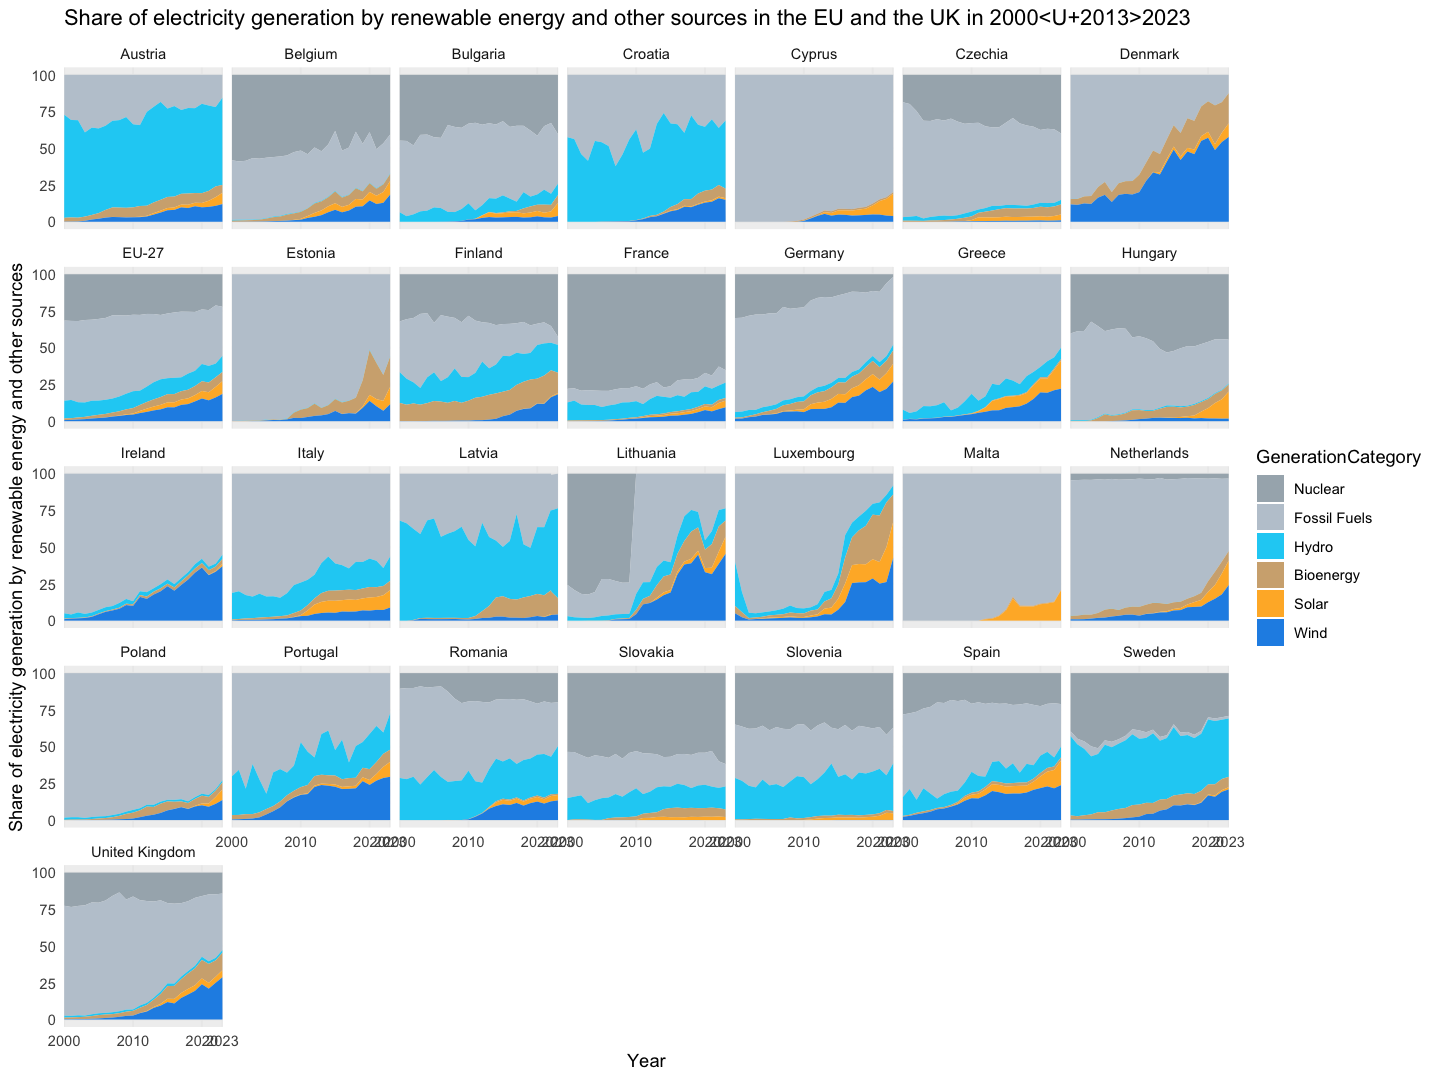

In [29]:
options(repr.plot.width = 12, repr.plot.height = 9)

# Generate a chart with English annotations.
ggplot(electricity_eu28_incl_eu27_total_relative,
              aes(x = Year, y = RelativeValue)) +
  geom_area(aes(fill = GenerationCategory)) +
  facet_wrap(vars(CountryNameEn), nrow = 5, ncol = 7) +
  scale_fill_source_category() +
  theme_minimal() +
  theme(panel.grid.minor = element_blank(),
        panel.background = element_rect(fill = "#f0f0f0", color = "#f0f0f0")) +
  coord_cartesian(ylim = c(0, 100)) +
  scale_x_continuous(breaks = c(2000, 2010, 2020, 2023), expand = c(0,0)) +
  labs(x = "Year",
       y = "Share of electricity generation by renewable energy and other sources",
       title = "Share of electricity generation by renewable energy and other sources in the EU and the UK in 2000–2023")

# Save plot in an svg file.
ggsave("../outputs/electricity-eu-res-en.svg", width = 26.7, height = 16.7)


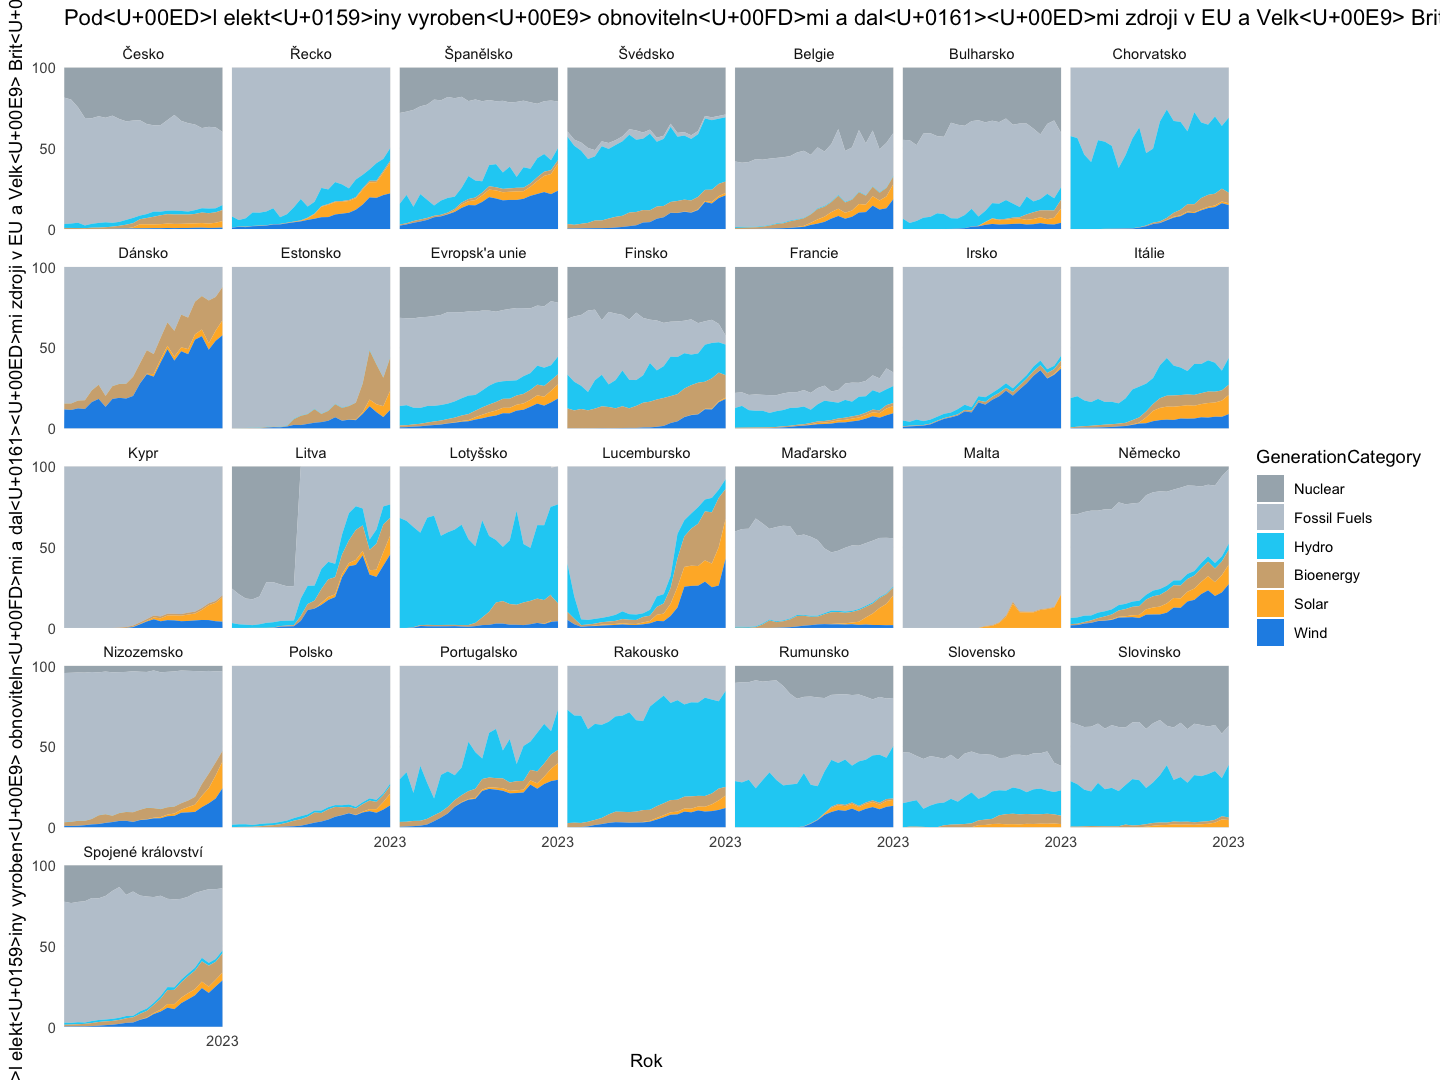

In [30]:
options(repr.plot.width = 12, repr.plot.height = 9)

# Generate a chart with Czech annotations.
ggplot(electricity_eu28_incl_eu27_total_relative,
              aes(x = Year, y = RelativeValue)) +
  geom_area(aes(fill = GenerationCategory)) +
  facet_wrap(vars(CountryNameCs), nrow = 5, ncol = 7) +
  scale_fill_source_category() +
  theme_minimal() +
  theme(panel.grid.minor = element_blank(),
        panel.background = element_rect(fill = "#f0f0f0", color = "#f0f0f0")) +
  coord_cartesian(ylim = c(0, 100)) +
  scale_x_continuous(breaks = c(2023), expand = c(0,0)) +
  scale_y_continuous(breaks = c(0, 50, 100, 120), expand = c(0,0)) +
  labs(x = "Rok",
       y = "Podíl elektřiny vyrobené obnovitelnými a dalšími zdroji v EU a Velké Británii v %",
       title = "Podíl elektřiny vyrobené obnovitelnými a dalšími zdroji v EU a Velké Británii v letech 2000–2023")

# Save plot in an svg file.
ggsave("../outputs/electricity-eu-res-cs.svg", width = 26.7, height = 16.7)

## Data for accompanying text

The following code generates data mentioned in the accompanying text:
* Countries that imported more than 10% of their electricity demand in the last three years.
* Total RES share per country and year.
* Change in RES share in electricity generation between 2000 and 2023.

In [49]:
# Calculate which countries imported more than 10% of their electricity demand in the last three years.
generation_demand_ratio <- filter(electricity_eu28, GenerationCategory %in% c("Demand", "Total Generation")) |>
  pivot_wider(names_from = GenerationCategory, values_from = ValueTWh) |>
  mutate(Ratio = (Demand - `Total Generation`) / Demand * 100) |>
  filter(Year %in% c(2020:2023), Ratio >= 10)

head(generation_demand_ratio)

CountryCode,Year,Demand,Total Generation,Ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AUT,2021,74.22,66.68,10.15899
AUT,2022,72.95,64.25,11.92598
HRV,2020,17.87,13.23,25.96530
HRV,2021,19.07,15.11,20.76560
HRV,2022,18.93,14.24,24.77549
DNK,2020,35.46,28.58,19.40214


In [57]:
# Calculate total RES shares for each country and year and transform the dataframe.
res_ratio <- filter(electricity_eu28_incl_eu27_total_relative, GenerationCategory %in% c("Wind", "Solar", "Hydro", "Bioenergy")) |>
  select(-ValueTWh) |>
  pivot_wider(names_from = GenerationCategory, values_from = RelativeValue) |>
  mutate(ResInclHydro = (Wind + Solar + Bioenergy + Hydro)) |>
  mutate(ResExcllHydro = (Wind + Solar + Bioenergy)) |>
  filter(Year %in% c(2000, 2023))

head(res_ratio)

CountryCode,Year,CountryNameEn,CountryNameCs,Total,Bioenergy,Hydro,Solar,Wind,ResInclHydro,ResExcllHydro
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AUT,2000,Austria,Rakousko,59.64,2.5653924,70.1542589,0.000000,0.11737089,72.837022,2.6827632
AUT,2023,Austria,Rakousko,66.96,5.3315412,59.4235364,7.706093,12.02210275,84.483274,25.0597372
BEL,2000,Belgium,Belgie,82.79,0.6884889,0.5556227,0.000000,0.02415751,1.268269,0.7126465
BEL,2023,Belgium,Belgie,82.40,4.7694175,0.4611650,9.296117,18.53155340,33.058252,32.5970874
BGR,2000,Bulgaria,Bulharsko,40.59,0.0000000,6.4794284,0.000000,0.00000000,6.479428,0.0000000
BGR,2023,Bulgaria,Bulharsko,39.99,5.4513628,7.7769442,8.802201,3.87596899,25.906477,18.1295324


In [62]:
# Calculate change of RES share in electricity generation between 2000 and 2023.
res_diff <- res_ratio |>
  select(Year, CountryNameEn, ResInclHydro) |>
  pivot_wider(names_from = Year, values_from = ResInclHydro) |>
  mutate(Diff2000_2023 = `2023`-`2000`) |>
  select(CountryNameEn, Diff2000_2023)

head(res_diff)

CountryNameEn,Diff2000_2023
<chr>,<dbl>
Austria,11.64625
Belgium,31.78998
Bulgaria,19.42705
Croatia,11.45205
Cyprus,20.22263
Czechia,11.74510
